# Part 2: Supervised Learning
## (First Trial of Part 2)
 Part 1 created the labels. Now, can AI predict these labels correctly?

### 1) Load files and create target labels¶

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Read the JSON file
with open('data/result/countries_per_cluster.json', 'r', encoding='utf-8') as f:
    cluster_json = json.load(f)

# Convert JSON data to {ClusterID: [Country List]} format
clusters_data = {}
for item in cluster_json:
    clusters_data[item['cluster_kmeans']] = item['countries']

# Convert to a flat list: [Country, ClusterID]
country_cluster_list = []
for cluster_id, countries in clusters_data.items():
    for country in countries:
        country_cluster_list.append({'Country': country, 'Cluster': cluster_id})

df_target = pd.DataFrame(country_cluster_list)

### 2) Prepare Feautes X (AGGREGATED)

In [2]:
# Read the High Variance file
df_features_raw = pd.read_csv('data/processed/country_index_matrix_HIGH_VARIANCE.csv')

# Take the 3-year AVERAGE for each country and reduce to one row
numeric_cols = df_features_raw.select_dtypes(include=[np.number]).columns
df_features = df_features_raw.groupby('Country')[numeric_cols].mean().reset_index()

print(f" Feature data is ready (averages). Shape: {df_features.shape}")

 Feature data is ready (averages). Shape: (70, 25)


We have a really small dataset now since we use averages, this might be a problem

### 3) Merge Datasets

In [3]:
# Merge X and Y using the 'Country' column
df_final = pd.merge(df_features, df_target, on='Country', how='inner')

# Set country name as index 
df_final.set_index('Country', inplace=True)

print(f"Final shape: {df_final.shape} (Rows=Countries, Columns=Features+Cluster)")

Final shape: (70, 25) (Rows=Countries, Columns=Features+Cluster)


### 4) Model Training and Testing

In [4]:
X = df_final.drop(columns=['Cluster']) 
y = df_final['Cluster']                

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# 80% Train, 20% Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} countries")
print(f"Test set:     {X_test.shape[0]} countries")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (Linear)": SVC(kernel='linear', random_state=42),
    "k-NN (5-Neighbors)": KNeighborsClassifier(n_neighbors=5)
}

results = []
print("\nModel Performance (Aggregated Data)")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})
    print(f"{name:<20}: %{acc*100:.1f}")

Training set: 56 countries
Test set:     14 countries

Model Performance (Aggregated Data)
Logistic Regression : %92.9
Decision Tree       : %42.9
Random Forest       : %50.0
SVM (Linear)        : %92.9
k-NN (5-Neighbors)  : %64.3


### 5) Visualization

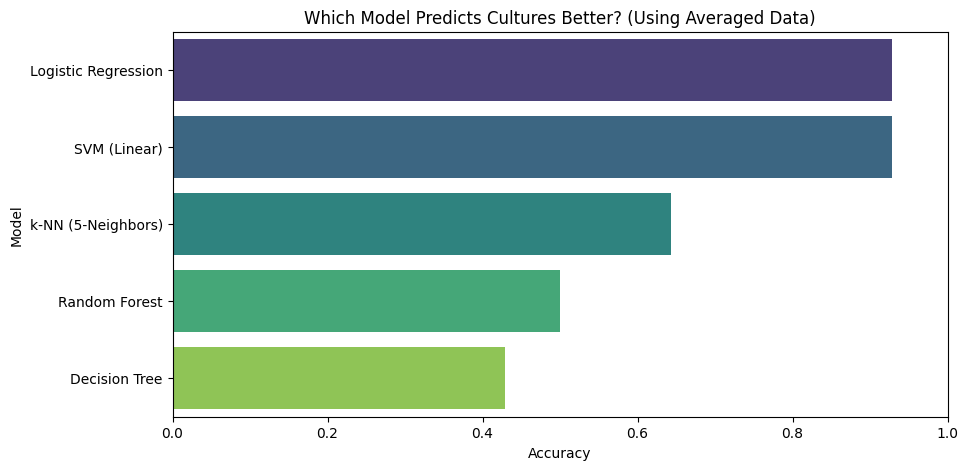

In [5]:
df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(10, 5))

sns.barplot(x='Accuracy', y='Model', hue='Model',data=df_results,palette='viridis', legend=False)

plt.title('Which Model Predicts Cultures Better? (Using Averaged Data)')
plt.xlim(0, 1.0)
plt.show()

**Success of Linear Models:** Simple linear models (Logistic Regression and Linear SVM) achieved the highest accuracy (92.9%). This indicates that the cultural clusters are linearly separable in the feature space; distinct boundaries exist between groups even when averaged.

**Failure of Tree-Based Models:** Conversely, complex ensemble models like Random Forest performed poorly (50.0%), barely exceeding random chance. This is an example of Overfitting due to the "Small Data" problem. With only 70 samples, the Random Forest model memorized the training data but failed to generalize to unseen test countries.

**Conclusion:** This result validates the need to transition from static averages to a weekly time-series approach, increasing the sample size to enable robust training for non-linear models.